# Covid 19 : India Analysis and Forecasting
TO DO <br>
CHANGE TO LASSO REGRESSION

## Note: 
<p> The author doesn't claim to have any domain knowledge and isn't an epidemiologist. The analysis in this notebook is just an attempt to learn new techniques and gather potential insights from the available data but shouldn't be taken seriously. </p>

In [1]:
from plotly.offline import init_notebook_mode
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from matplotlib import dates as dt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import seasonal, stattools, arima_model
from statsmodels.tsa.statespace import sarimax
from IPython.display import display
from xgboost import XGBRegressor

plt.style.use('seaborn')
init_notebook_mode(connected=True)

# 1. Grabbing Data
TO DO :
1. Move helper functions to Utils. 
2. See if you can grab updated WW data.

### A. Using Kaggle Challenge Dataset 
Stored Locally.

In [3]:
path_train = 'covid19-global-forecasting-week-4/train.csv'
path_test = 'covid19-global-forecasting-week-4/test.csv'
path_sbumit = 'covid19-global-forecasting-week-2/submission.csv'

train_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/train.csv'
test_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/test.csv'
submit_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/submission.csv'

path_graphs = 'Graphs/'

In [4]:
df_train_count = pd.read_csv(path_train)
df_test_count = pd.read_csv(path_test)
df_train_count.rename(columns={'Country_Region': 'Country/Region',
                               'Province_State': 'Province/State'}, inplace=True)
df_test_count.rename(columns={'Country_Region': 'Country/Region',
                              'Province_State': 'Province/State'}, inplace=True)

#### Helper Functions For Kaggle Dataset : 1. To filter DataFrame according to Country.

In [2]:
def country_df(country, df):
    """Filters a Dataframe according to Country.
    Args: 
    country: String. Name of country for which dataframe is to be filtered for.
    df: Dataframe. The Dataframe that is to be filtered.
    Returns: 
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    """
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(
            ['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()

    return df_cases, df_fatal

#### 2. To Prepare Model Train data.

In [3]:
def prepare_train_data(df_cases, df_fatal):
    """Splits ConfirmedCases and Fatalities dataframe into training features and labels.
    Args:
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    Returns:
    x_train: np array. Array of integers denoting days since firstday of original df for model training features.
    y_cases: List. List of Confirmed Cases as labels for model from first day of original df.
    y_fatal: List. List of Fatalities as labels for model from first day of original df.
    """
    x_train = np.arange(0, len(df_cases)).reshape(-1, 1)
    y_cases = df_cases.to_list()
    y_fatal = df_fatal.to_list()

    return x_train, y_cases, y_fatal

#### 3. For Plotting Actual and Predicted Metrics after modelling.

In [59]:
def plot_actual_predicted(country, label,  y_cases, y_pred, show_lockdown=False, start_date='2020-01-22'):
    """Plots the Actual and Predicted ConfirmedCases/Fatalities for a country.
    Args:
    country(string) country name.
    y_cases, y_pred (array/list) - Actual And Predicted Metrics.
    label(string) - Which metric is being passed.
    Returns:
    """

    xtick_locator = AutoDateLocator()
    xtick_formatter = AutoDateFormatter(xtick_locator)

    # generating dates using pandas, can be used with date_plot.
    train_times = pd.date_range(start=start_date, periods=len(y_cases))
    test_times = pd.date_range(start=start_date, periods=len(y_pred))
    dates = train_times.to_series().dt.date
    dates_test = test_times.to_series().dt.date

    # converting to Series, list
    d_train = dates.tolist()
    d_test = dates_test.tolist()

    # getting date_format variable for matplotlib and lockdown date.
    date_format = dt.DateFormatter('%b, %d')

    # converting lockdown date string to datetime.
    lockdown_date_str = '2020-03-25'
    lockdown_date = datetime.datetime.strptime(lockdown_date_str, '%Y-%m-%d')

    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(17)
    fig.autofmt_xdate()
    ax.plot_date(d_train, y_cases, label='Actual Values',
                 linestyle='solid', marker=None)
    ax.plot_date(d_test, y_pred, label='Predicted Values',
                 linestyle='solid', marker=None)
    ax.set_title(
        f'{country} : {label}')
    ax.set_ylabel(f'No of {label}')
    if show_lockdown:
        ax.plot_date([lockdown_date, lockdown_date],
                     plt.gca().get_ylim(), 'r-', label='Lockdown')
    ax.xaxis.set_major_formatter(date_format)
    ax.legend()
    #fig.savefig( path_graphs + f'{country}_conf_case.jpg')

### B. Getting Data Using Covid19India.org API
Fetches JSON from the Covid19.org API and creates dataframe of Daily and Total Cases, Recovered, Deceased.<br>
Testing data from Datameet ICMR backup JSON.

In [2]:
from india_API_data.Covid19_india_org_api import make_dataframe
from india_API_data.Covid19_india_org_api import get_test_dataframe

### C. Grabbing Data from SQLite DB
Uses the data grabbed from B. which has been stored in a SQLite database to avoid repeatedly fetching data from the API. Data may not be latest. Run Ingest_to_DB.py as a script to get latest data into database or Function can fetch new data using parameter fetch_new = Bool. Default table name 'covid'. 

In [3]:
from Ingest_to_DB import data_to_df

#### Helper Functions For API Data : 1. Plotting Metrics

In [7]:
def plot_daily(df, columns, save=False, log=False):
    """ Helper Function to Plot Current Metrics from API data.
    Args: 
    df (Dataframe) - Dataframe of API data create Using Make_dataframe.
    columns (List of column names)
    save(Bool) - Whether to save fig.
    Returns:
    """
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    plt.style.use('seaborn')
    plt.title('Daily Trends: India (From API)')
    plt.ylabel('No. Of Individuals')
    plt.xlabel('Date')
    fig.autofmt_xdate()
    for item in columns:
        plt.plot_date(x=df.index, y=df[item],
                      label=item, linestyle='solid', marker=None)
    plt.legend()
    if save == True:
        fig.savefig(path_graphs + save + 'India_Cumulative_stats.png')
    if log == True:
        plt.yscale('log')
        plt.title('Daily Trends(Log): India (From API)')
    plt.show()

# 2. Visualizations & Analysis


## Logistic Curve or S- shaped Curve : Comparing Epidemic Behaviour
<p>From the 3blue1brown video, epidemics are observed to follow a logistic curve. The no. of infected rises exponentially and reaches an inflection point before gradually decreasing. This can be somewhat seen in China's Confirmed Cases plot.</p>
$$f{(x)} = \frac{L}{1 + e^{-k(x - x_0)}}$$
Here x0 = the x value of the sigmoids' midpoint. <br>
L = the curve's maximum value. <br>
k = the logistic growth rate or steepness of the curve.

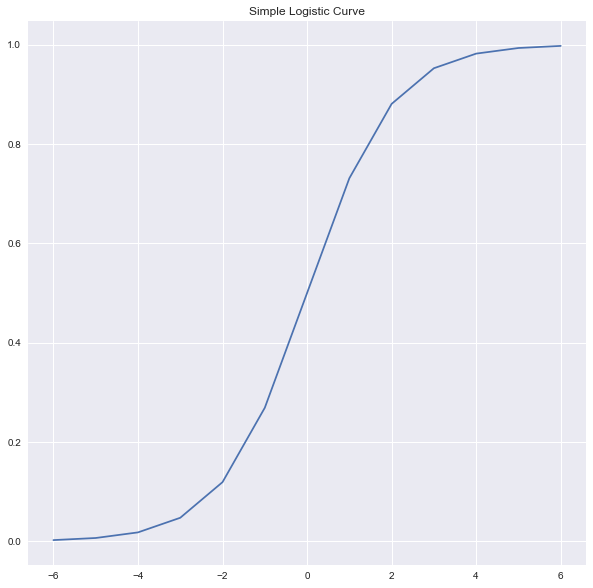

In [8]:
# Plotting a simple logistic curve using numpy and matplotlib.
# x = (-6,6), L =1, k = 1, x0 =0
x = np.arange(-6, 7)
power = -1*x
y = 1 / (1 + np.exp(power))

plt.figure(figsize=(10, 10))
plt.title('Simple Logistic Curve')
plt.grid(True)
plt.plot(x, y)
plt.show()

## This behaviour can be somewhat seen in the case of China

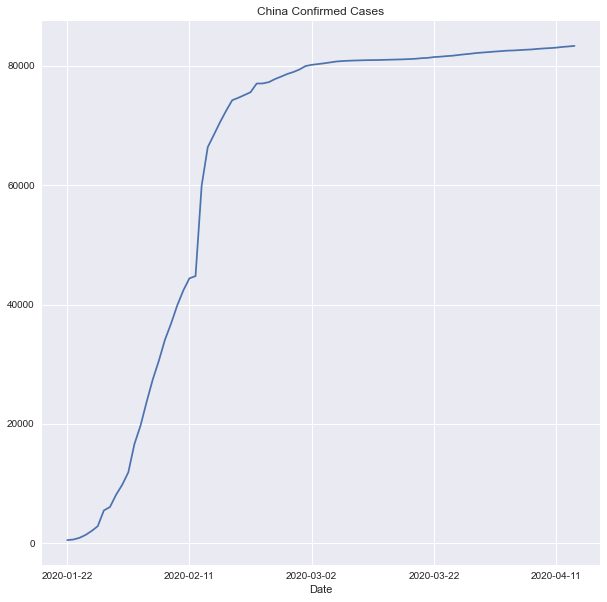

In [11]:
china_cases, china_fatal = country_df('China', df_train_count)
china_cases.plot(figsize=(10, 10), title='China Confirmed Cases', grid=True)
plt.show()

## Worlwide Cases

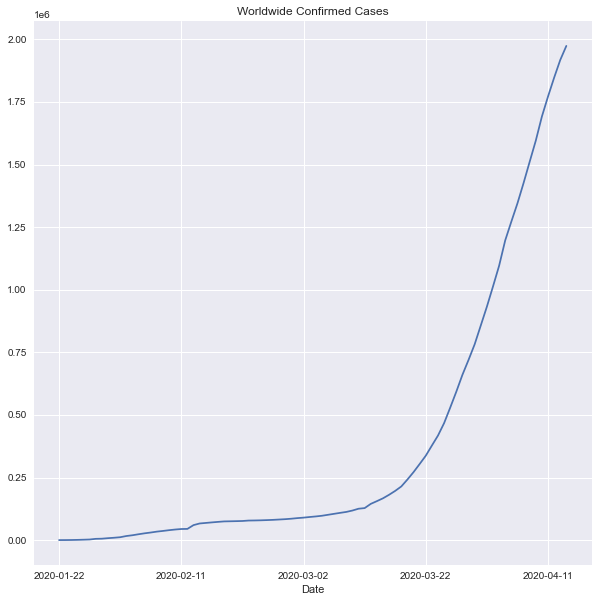

In [12]:
world_cases, world_fatal = country_df('World', df_train_count)
world_cases.plot(figsize = (10,10), title = 'Worldwide Confirmed Cases', grid = True)
plt.show()

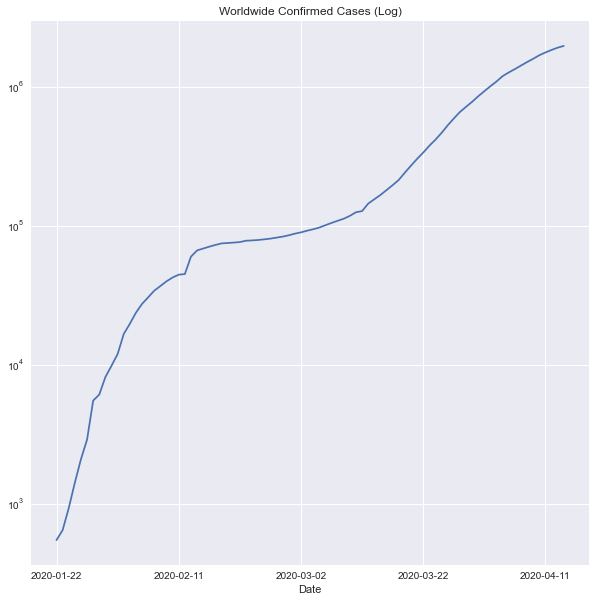

In [13]:
world_cases.plot(figsize = (10,10), title = 'Worldwide Confirmed Cases (Log)', grid = True, logy = True)
#ax = plt.gca()
#plt.plot([ax.get_xlim()[0],ax.get_xlim()[1]],[ax.get_ylim()[0],ax.get_ylim()[1]])
plt.show()

1. The Number of People getting infected is still growing, but to check whether it is growing exponentially we have to use the log scale.
2. The data plotted on the log Scale shows that the growth Seems to be touching the green line representing exponential growth. This could be a temporary Dip Before another wave and does not guarantee that the inflection point of the initial exponential growth has been reached.

## India - Current Statistics

In [4]:
#india_data = make_dataframe()
india_data = data_to_df('covid', fetch_new=False)
india_data.date = pd.to_datetime(india_data.date)
india_data.set_index('date', inplace=True)
india_data = india_data.astype('float')

pd.options.plotting.backend = "plotly"
fig = india_data[['DailyConfirmed', 'DailyDeceased',
                  'DailyRecovered']].iloc[40:].plot(title=' Daily Trends: India')
fig.update_layout(yaxis=dict(title='Number of Patients'),
                  legend_title_text='Statistic', legend=dict(x=.85, y=1.24))

In [5]:
fig = india_data[['DailyConfirmed', 'DailyDeceased',
                  'DailyRecovered']].rolling(window=7).mean().iloc[40:].plot(title=' 7 Day Moving Average : India')
fig.update_layout(yaxis=dict(title='Number of Patients'),
                  legend_title_text='Statistic', legend=dict(x=.85, y=1.24))

In [6]:
fig = india_data[['TotalConfirmed', 'TotalDeceased',
                  'TotalRecovered']].iloc[40:].plot(title=' Cumulative Trend: India')
fig.update_layout(yaxis=dict(title='Number of Patients'),
                  legend_title_text='Statistic', legend=dict(x=.85, y=1.24))

### India Testing Statistics
The comparison of the graphs of the amount of Testing Done and the confirmed Cases each day can be a good indicator of whether enough testing is being done. If the curves are very close by it can indicate that not enough people are getting tested. Visualising the Daily confirmed cases and Testing Samples collected on a semi-log graph shows that the number of confirmed cases per day is increasing at a faster rate than the Testing Rate although this is understandably skewed due to the log axis. <br>
Looking at the comparison and observing the sharp increase in samples collected, we can say that testing is finally being done on a larger scale. (Testing Data from 03-13. Sharper increase in April). <br>
Also observe the weekly seasonality in testing samples collected.

In [7]:
fig = india_data[['TestingSamples']].iloc[40:].diff(
    1).plot(title=' Daily Testing Trends: India')
fig.update_layout(yaxis=dict(title='Number of Samples Tested'),
                  legend_title_text='No. of Testing Samples Collected per day by ICMR', legend=dict(x=.65, y=1.15))

In [8]:
fig = india_data[['TestingSamples', 'TotalConfirmed']].iloc[40:].diff(
    1).plot(title=' Daily Testing and New Cases : India')
fig.update_layout(yaxis=dict(title='Number of Samples Tested, Total Confirmed Cases '),
                  legend_title_text='Daily Stats', legend=dict(x=.85, y=1.15))

In [9]:
fig = india_data[['TestingSamples', 'TotalConfirmed']].iloc[40:].diff(
    1).plot(title=' Daily Testing and New Cases(Log) : India')
fig.update_layout(yaxis=dict(title='Number of Samples Tested, Total Confirmed Cases '),
                  legend_title_text='Daily Stats', yaxis_type="log", legend=dict(x=.85, y=1.15))

In [10]:
#plot_daily(india_combined_data, ['TotalConfirmed', 'Testing Samples'])#, save='Cofirmed_testing_samples_')

### Growth Factor (R Number ) Of Virus
<p>
    The growth factor on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.
     <br>Measure of whether the disease is growing or not. </p>
1. A value of greater than 1 = growth. <br>
2. Less than 1 = decline. <br>
3. A growth factor of 1 is the inflection point and at this point the disease is not increasing.

<p>
As of 24th April, it can be seen that the growth of the virus <b>hasn't stabilised at the inflection point but is much lower than the mean growth factor upto this point indicating that the initial exponential growth might be over. </b><br>
The Linear Regression on the Growth Factor seems to point to a downward trend in the Growth Factor but the margin of error is high.

In [11]:
def growth_factor(confirmed):
    confirmed_nminus1 = confirmed.shift(1, axis=0)
    confirmed_nminus2 = confirmed.shift(2, axis=0)
    return ((confirmed - confirmed_nminus1)/(confirmed_nminus1 - confirmed_nminus2))

In [12]:
india_growth_factor = growth_factor(india_data.TotalConfirmed[41:])
india_growth_factor.rename(index = 'Growth Factor', inplace=True)
print(f'Mean Growth Factor : {india_growth_factor.mean()}')
print(f'Mean Growth Factor of the last 10 days : {india_growth_factor[-10:].mean()}')

Mean Growth Factor : 1.077983319490635
Mean Growth Factor of the last 10 days : 1.0093359806495061


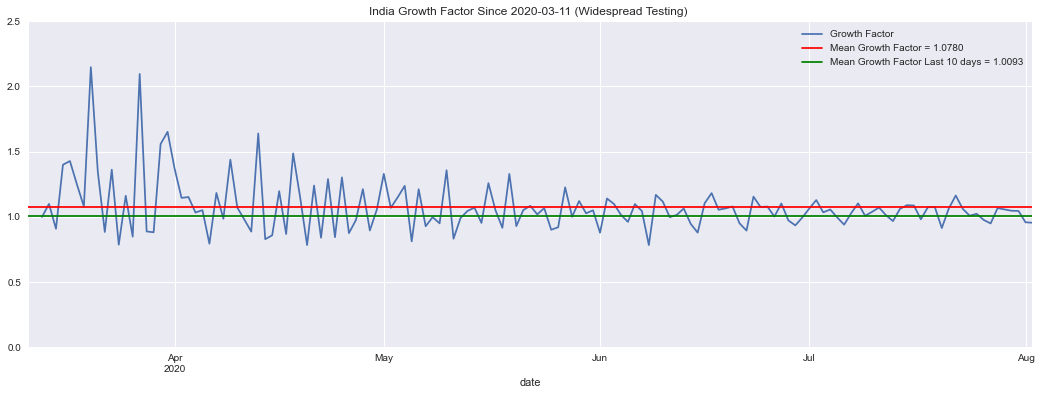

In [13]:
pd.options.plotting.backend = 'matplotlib'
india_growth_factor.plot(grid=True, title='India Growth Factor Since 2020-03-11 (Widespread Testing) ',
                         figsize=(18, 6), ylim=(0, 5))
plt.ylim(0, 2.5)
plt.axhline(india_growth_factor.mean(), color='r',
            label=f'Mean Growth Factor = {india_growth_factor.mean():.4f}')
plt.axhline(india_growth_factor[-10:].mean(), color='g',
            label=f'Mean Growth Factor Last 10 days = {india_growth_factor[-10:].mean():.4f}')
plt.legend()
#plt.savefig(path_graphs + 'India_Growth_Factor')
plt.show()

#### Linear Regression on Growth Factor.
This points to downwards trend, however due to not enough early testing there are outliers with very high growth rate. The confidence interval shows that a slight upwards curve is also possible, so the results need to be interpreted with caution. Removing the outliers resulted in a tighter confidence interval but have not been removed. Looking at the Residualplot, there appears to be an initial non-linear relationship between the growth factor and the time series of days since first case/data availability. This has been investigated later.

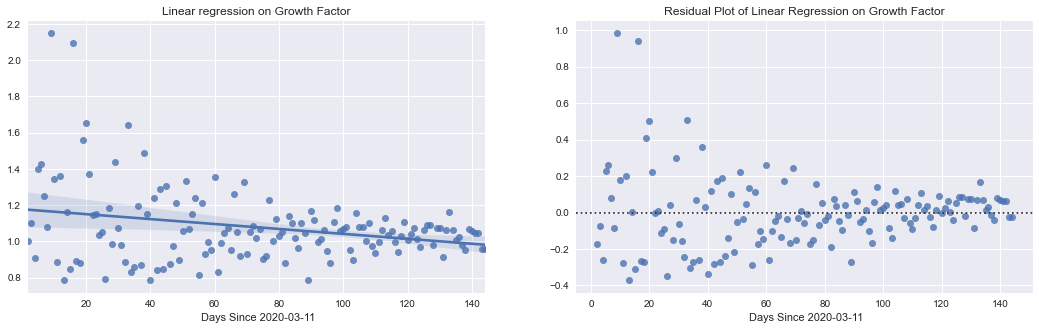

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sns.regplot(x=np.arange(len(india_growth_factor.index.tolist())),
            y=india_growth_factor.to_list(), ax=ax[0])
ax[0].set_title('Linear regression on Growth Factor')
ax[0].set_xlabel(' Days Since 2020-03-11')
sns.residplot(x=np.arange(len(india_growth_factor.index.tolist())),
              y=india_growth_factor.to_list(), ax=ax[1])
ax[1].set_title('Residual Plot of Linear Regression on Growth Factor')
ax[1].set_xlabel(' Days Since 2020-03-11')
#plt.savefig(path_graphs +'India_Growth_Factor_Pred')
plt.show()

### Growth Ratio of Virus
The growth ratio on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.
Percentage Increase in total cumulative Cases from one day to the next. <br>
Looking at the graph, there is an unmistakable downward trend to the growth ratio, with a 6% growth in the number of cases occuring on the 24th April compared  to highs of 25-30% since the start of reliable testing. A linear relationship does not appear to be a suitable realtionship according to the residual plot and an exponential decay could be more suitable.

 Mean growth Ratio of Cases In India : 1.0744347334814073


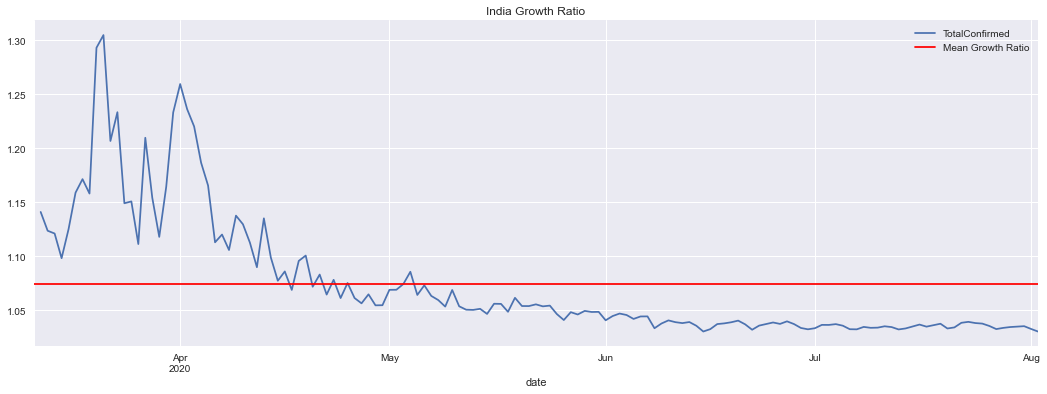

In [15]:
growth_ratio_india = india_data.TotalConfirmed[41:]/india_data.TotalConfirmed[41:].shift(1)
print(f' Mean growth Ratio of Cases In India : {growth_ratio_india.mean()}')
growth_ratio_india.plot(grid = True, title = 'India Growth Ratio', figsize = (18,6))
plt.axhline(growth_ratio_india.mean(), color = 'r', label='Mean Growth Ratio')
plt.legend()
#plt.savefig(path_graphs + 'India_Growth_Ratio')
plt.show()

#### Try Poisson Regression
https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html

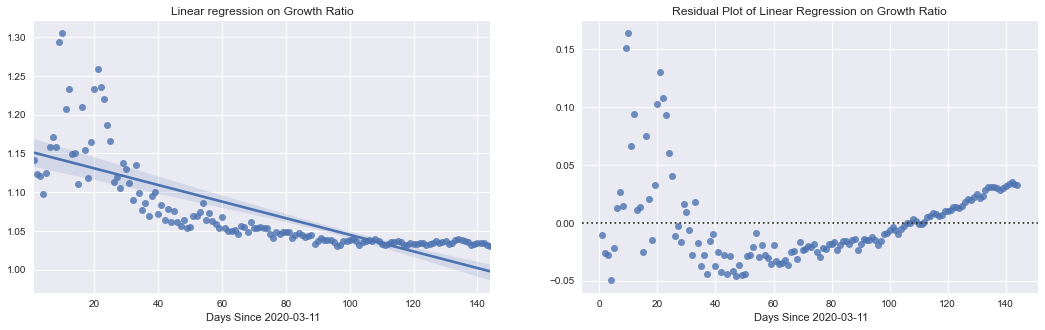

In [16]:
fig, ax = plt.subplots(1,2, figsize = (18,5))
sns.regplot(x = np.arange(len(growth_ratio_india.index.tolist())) , y =growth_ratio_india.to_list(), ax = ax[0])
ax[0].set_title('Linear regression on Growth Ratio')
ax[0].set_xlabel(' Days Since 2020-03-11')
sns.residplot(x = np.arange(len(growth_ratio_india.index.tolist())) , y =growth_ratio_india.to_list(), ax =  ax[1] )
ax[1].set_title('Residual Plot of Linear Regression on Growth Ratio')
ax[1].set_xlabel(' Days Since 2020-03-11')
#plt.savefig(path_graphs +'India_Growth_Factor_Pred')
plt.show()

# 3. Modeling - Regularized Ridge Regression
<p>Due to a scarcity of features, the results should be taken with a grain of salt and are heavily influenced by the predictive power of the feature days since the outbreak .</p> First, the Growth factor and Growth Ratio are predicted for 'z' number of days using Ridge Regression. Ridge Regression applies half of the squared l2 norm of the weight vector as a regularization term or penalty to reduce overfitting and improve generalisation performance. This reduces in-sample training accuracy but will help the model generalise better in the absence of a large amount of features and training data.</p>
<p><b>Predictions: </b> The model has 86% validation set accuracy and a MSE of 13631. Using the Model to Predict the Total Confirmed Cases upto the next year, we see a maximum or plateau of 1,4 million confirmed Cases before the Total number of Active Cases starts to slow down around the January, Next Year.</p>

#### Growth Factor Predictions for the next 'z' Days

In [17]:
z = 31

#### Linear Regression to get Predicted Growth Factor
<p>The parameters for the ridge regression were found using the best validation set score using gridsearchCV</p>

In [18]:
# X is just days from 03-10
# Target is the growth factor on these days
# First two values from GF is nan, so from 03-12 to Current day used for training

In [19]:
# So, creating Features excluding first two days.
# x is days since 03-12
x = pd.DataFrame(index=pd.date_range(start='2020-03-13', periods=len(india_growth_factor.to_list())), 
            data = {'Days_since_03_12' : np.arange(1, len(india_growth_factor.to_list())+1)})
# Since growth factor calculation removes last two points 
x = x[:-2]
y = india_growth_factor.to_list()[2:]

In [20]:
# Growth factor of last two days can't be calculated, so - truncating x by 2 days
pipe_gf = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = 5))])
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = .3, shuffle = False)
pipe_gf.fit(x_train,y_train)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                ('ridge', Ridge(alpha=5))])

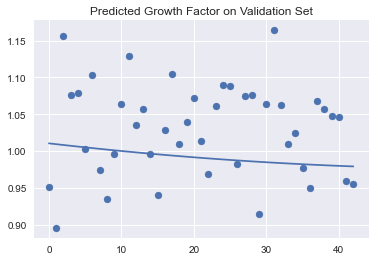

In [21]:
plt.scatter(x =np.arange(0, len(x_test)) ,y = y_test)
plt.plot(pipe_gf.predict(x_test))
plt.title('Predicted Growth Factor on Validation Set')
plt.show()

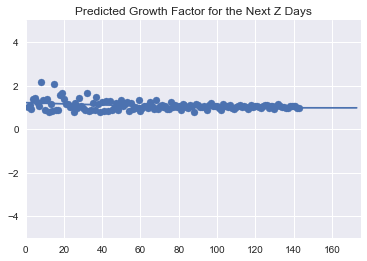

In [22]:
plt.scatter(x, y)
plt.ylim(-5,5)
plt.xlim(0,175)
plt.plot(pipe_gf.predict(np.arange(1, len(x)+1+z ).reshape(-1,1)))
plt.title('Predicted Growth Factor for the Next Z Days')
plt.show()

In [23]:
# Saving Predicted Grwoth Factor
pipe_gf.fit(x,y)
y_gf_pred = pipe_gf.predict(np.arange(len(x)-1, len(x)+z).reshape(-1,1))

#### Linear Regression to get Predicted Growth Ratio
<p>The parameters for the ridge regression were found using the best validation set score using gridsearchCV</p>

In [24]:
x = pd.DataFrame(index=pd.date_range(start='2020-03-13', periods=len(india_growth_factor.to_list())), 
            data = {'Days_since_03_12' : np.arange(1, len(india_growth_factor.to_list())+1)})
# Since growth Ratio calculation removes last two points 
x = x[:-2]
y_gr = growth_ratio_india.to_list()[2:]

In [25]:
pipe_gr = Pipeline([('poly', PolynomialFeatures(degree = 2)), ('scale', StandardScaler()),('ridge', Ridge(alpha = 5))])
pipe_gr.fit(x, y_gr)

Pipeline(steps=[('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                ('ridge', Ridge(alpha=5))])

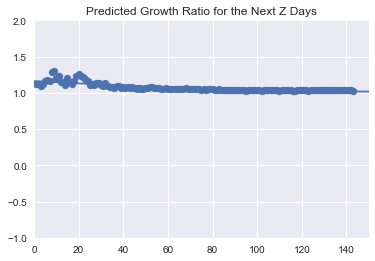

In [26]:
plt.scatter(x, y_gr)
plt.ylim(-1,2)
plt.xlim(0,150)
plt.plot(pipe_gr.predict(np.arange(1,len(x)+1+z).reshape(-1,1)))
plt.title('Predicted Growth Ratio for the Next Z Days')
plt.show()

In [27]:
# Saving These Predictions
y_gr_pred = pipe_gr.predict(np.arange(len(x)-1, len(x)+z).reshape(-1,1))

#### Storing Predicted Growth Factor and Ratio in Dataframe

In [74]:
x_pre = pd.DataFrame(index=pd.date_range(start=datetime.datetime.strftime(x[-1:].index[0] + datetime.timedelta(days=1),
                                                                          '%Y-%m-%d'), periods=32),
                     data={'Days_since_03_12': np.arange(len(x)+1, len(x)+z+2),
                           'GrowthFactor': y_gf_pred, 'GrowthRatio': y_gr_pred})

### Feature Engineering

####  Using Growth Factor as a feature

In [75]:
# Imputing Missing values with mean of growth factor from 11-03 to present day.
# df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
india_data = data_to_df('covid')
india_data.date = pd.to_datetime(india_data.date)
india_data.set_index('date', inplace=True)
india_growth_factor_1 = growth_factor(india_data.TotalConfirmed[:])
india_growth_factor_1.replace(np.nan, india_growth_factor.min(), inplace=True)
india_growth_factor_1.replace(np.inf, india_growth_factor.min(), inplace = True)
india_growth_factor_1 = india_growth_factor_1.to_frame()
india_growth_factor_1.rename({'TotalConfirmed': 'GrowthFactor'}, axis=1, inplace=True)
# Merging the two dataframes
india_data = pd.concat([india_data, india_growth_factor_1], axis = 1)

####  Using Growth Ratio as a feature

In [76]:
growth_ratio_india_1 = india_data.TotalConfirmed[:]/india_data.TotalConfirmed[:].shift(1)
growth_ratio_india_1.replace(np.nan, 1, inplace = True)
growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)
#growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)
# Merging the two dataframes
india_data = pd.concat([india_data, growth_ratio_india_1], axis = 1)

#### Train Data
Reserving last 62 days for validation set.

In [77]:
# Days since widespread data Availibity. 03-12

india_data['Days'] = 0
# -2 due to the fact that last two growth facotrs and ratios are predicted, would be leakage, dropping last two points
x = india_data[['Days','GrowthFactor', 'GrowthRatio']][43:]
x['Days'] = np.arange(1, len(india_data[43:])+1)
x['Day_week'] = x.index.dayofweek.values
y = india_data['DailyConfirmed'][43:]
# Not Shuffling time-Series Data.
x_train, x_test, y_train, y_test = x[:-62], x[-62:], y[:-62], y[-62:]

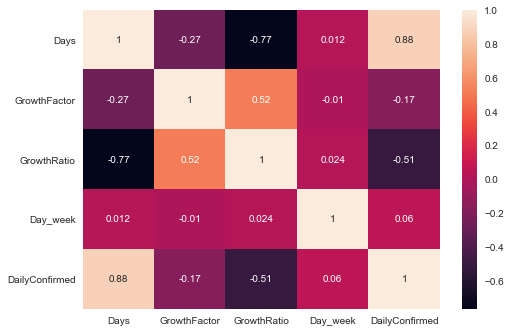

In [78]:
sns.heatmap(pd.concat([x, y], axis = 1).corr(method = 'pearson'), annot=True)

##  Lasso Regression
Has inbuilt regularisation in the form of L1 norm and also weighs down unimportant features.
<p> Hyperparameters found using Optimisation function below. The model seems to overfit using the days since substantial cases and is not a good indicator of long term predictions, it'll never go down and is likely to overestimate the Cases. Can be useful for short-term forecasting (1 month) here, compared to SARIMA later.</p>

### 1. Manual Hyperparameter Optimisation

In [79]:
def opt_alpha(list_alpha):
    # np.random.seed(10)
    res_r2 = []
    res_mse = []
    res_param = []
    for param in list_alpha:
        Input = [('poly', PolynomialFeatures(degree=4)), ('scale', StandardScaler()),
                 ('rid_reg', Lasso(alpha=param, max_iter=5000, tol=.001))]

        pipe = Pipeline(Input)
        pipe.fit(x_train, y_train)
        res_param.append(param)
        res_r2.append(pipe.score(x_test, y_test))
        res_mse.append(sqrt(mean_squared_error(y_test, pipe.predict(x_test))))
    return res_param, res_r2, res_mse

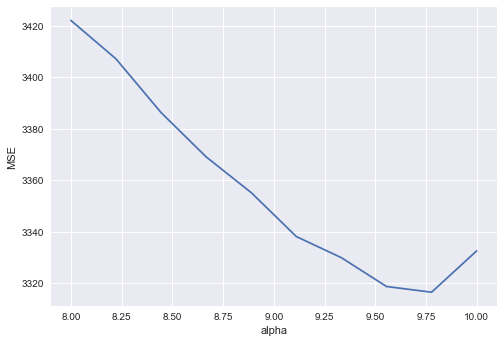

In [80]:
# Doesn't converge with current hyperparamters
param, r2, mse = opt_alpha(np.linspace(8,10, 10))
plt.plot(param , mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

In [81]:
Input = [('poly', PolynomialFeatures(degree= 4)), ('scale', StandardScaler()),
         ('rid_reg', Lasso(alpha = 9.75, max_iter=5000))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print('Test R2',pipe.score(x_test, y_test))
print('Test RMSE',sqrt(mean_squared_error(y_test, pipe.predict(x_test))))

Test R2 0.9357805573483451
Test RMSE 3745.5302967179246


### 2. Bayesian Hyperparameter Optimisation - Skopt

In [82]:
# Fix for some issue with Sklearn 0.23.0 and skopt 0.74
from numpy.ma import MaskedArray
import sklearn.utils.fixes

sklearn.utils.fixes.MaskedArray = MaskedArray

import skopt
from skopt.searchcv import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [112]:
# Pipeline 
Input = [('poly', PolynomialFeatures()), ('scale', StandardScaler()),
                 ('lasso', Lasso())]
pipe = Pipeline(Input)

In [113]:
# Parameter dictionary for pipeline

params = {'poly__degree' : Integer(2, 10, prior='uniform'),
         'lasso__alpha' : Real(1, 15, prior='uniform'),
         'lasso__max_iter' : Integer(5000, 10000, prior='uniform'),
         'lasso__tol' : Real(0.0001, .003, prior = 'uniform')}

In [114]:
# Passing the pipeline and search space as a list of touple of parameter dictionary and 
# the number of instances to be searched

opt = BayesSearchCV(pipe, [(params, 30)], cv=3)

In [115]:
opt.fit(x_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                        ('scale', StandardScaler()),
                                        ('lasso', Lasso())]),
              search_spaces=[({'lasso__alpha': Real(low=1, high=15, prior='uniform', transform='identity'),
                               'lasso__max_iter': Integer(low=5000, high=10000, prior='uniform', transform='identity'),
                               'lasso__tol': Real(low=0.0001, high=0.003, prior='uniform', transform='identity'),
                               'poly__degree': Integer(low=2, high=10, prior='uniform', transform='identity')},
                              30)])

In [116]:
print(f'val. score: {opt.best_score_}')
print(f'test score: {opt.score(x_test, y_test)}')

val. score: -3.2710258948251694
test score: 0.9484366455608328


In [117]:
opt.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('scale', StandardScaler()),
                ('lasso',
                 Lasso(alpha=15.0, max_iter=5000, tol=0.0019538738589817816))])

In [119]:
# Fitting pipeline with these parameters - Slightly better performance than Manual HyperOpt
Input = [('poly', PolynomialFeatures(degree= 4)), ('scale', StandardScaler()),
         ('rid_reg', Lasso(alpha = 15, max_iter=5000, tol=0.0019538738589817816))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print('Test R2',pipe.score(x_test, y_test))
print('Test RMSE',sqrt(mean_squared_error(y_test, pipe.predict(x_test))))

Test R2 0.9484366455608328
Test RMSE 3356.2216110594572


### Final Model Fit and Predictions

In [121]:
Input = [('poly', PolynomialFeatures(degree= 4)), ('scale', StandardScaler()),
         ('rid_reg', Lasso(alpha = 15, max_iter=5000, tol=0.0019538738589817816))]

pipe= Pipeline(Input)
pipe.fit(x_train, y_train)
print('Test R2',pipe.score(x_test, y_test))
print('Test RMSE',sqrt(mean_squared_error(y_test, pipe.predict(x_test))))

Test R2 0.9484366455608328
Test RMSE 3356.2216110594572


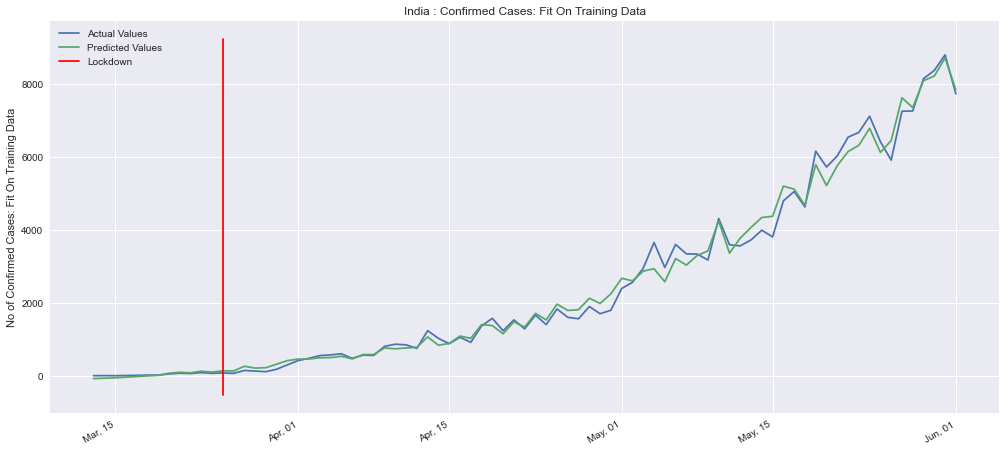

In [122]:
pipe.fit(x_train, y_train)
predictions_train = pipe.predict(x_train)
predictions_test = pipe.predict(x_test)
plot_actual_predicted('India', 'Confirmed Cases: Fit On Training Data',
                      y_train, predictions_train, show_lockdown= True, start_date='2020-03-13')

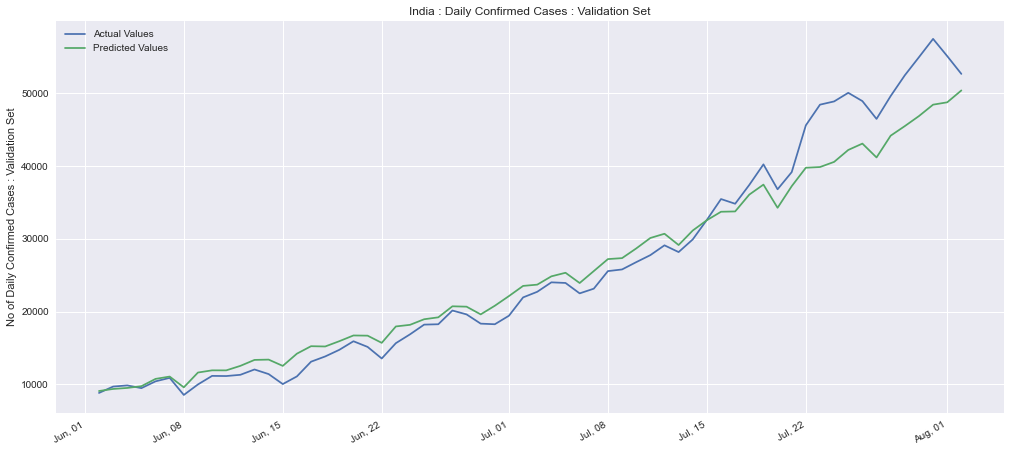

In [123]:
plot_actual_predicted('India', 'Daily Confirmed Cases : Validation Set', y_test,
                      predictions_test, show_lockdown= False,
                      start_date = y_test.index.date.min().strftime('%Y-%m-%d'))

## Forecast/Predictions

In [124]:
x_pre['Day_week'] = x_pre.index.weekday.values
pipe.fit(x, y)
predictions_z = pipe.predict(x_pre)
x_pre['Predicted_Daily_confirmed'] = predictions_z
# Total Confirmed Cases on the previous day - india_data.iloc[-1,4]
x_pre['Predicted_Total_confirmed'] = x_pre.Predicted_Daily_confirmed.copy()
x_pre.Predicted_Total_confirmed.iloc[0] = x_pre.Predicted_Daily_confirmed.iloc[0] + india_data.iloc[-1,4]
x_pre.Predicted_Total_confirmed = x_pre.Predicted_Total_confirmed.cumsum()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [125]:
# Saving Predictions
filename = 'Predictions_' + x_pre.index.min().strftime('%Y-%m-%d') + '_' + \
    x_pre.index.max().strftime('%Y-%m-%d')
x_pre.to_csv('Data/Predictions/'+ filename + '.csv')

In [126]:
pd.options.plotting.backend = "plotly"
fig = x_pre['Predicted_Daily_confirmed'].plot(title='Predicted Daily Cases: India')
fig.update_layout(yaxis=dict(title='Number of Cases'),
                  legend_title_text='Daily Predictions', legend=dict(x=.85, y=1.15),
                 xaxis = dict(title = 'Date'))

In [127]:
pd.options.plotting.backend = "plotly"
fig = x_pre['Predicted_Total_confirmed'].plot(title='Predicted Cumulative Cases: India')
fig.update_layout(yaxis=dict(title='Number of Cases'),
                  legend_title_text='Total Cases Predictions', legend=dict(x=.85, y=1.15),
                 xaxis = dict(title = 'Date'))

In [128]:
# Feature Importance 
feat_imp = pd.DataFrame(index = pipe['poly'].get_feature_names(x_pre.columns),
             data = pipe['scale'].inverse_transform(pipe['rid_reg'].coef_))
feat_imp.sort_values(by = 0, ascending=False)[:5]

,0
Days_since_03_12^4,1.645437e+12
Days_since_03_12^3,2.565762e+09
Days_since_03_12^2 Day_week,5.840199e+07
Days_since_03_12^2 GrowthFactor,9.739045e+06
Days_since_03_12^3 Day_week,2.306572e+06


### Comparing Predictions with Actual Cases

In [129]:
def compare_preds(preds_df):
    """Checks Predicted values against actual number of cases
    using API parsing script. 
    """
    temp = make_dataframe()
    comp = preds_df.join(temp, on=None, how='left')
    pd.options.plotting.backend = "plotly"
    fig = comp[['Predicted_Daily_confirmed', 'DailyConfirmed']].plot(
        title='Comparing Predicted Daily Cases: India')
    fig.update_layout(yaxis=dict(title='Number of Cases'),
                      legend_title_text='Daily Predictions', legend=dict(x=.85, y=1.15),
                      xaxis=dict(title='Date'))

    # Model Perfomance/Metrics
    r2 = r2_score(comp['DailyConfirmed'].dropna(
    ), comp['Predicted_Daily_confirmed'][:len(comp['DailyConfirmed'].dropna())])
    mse = mean_squared_error(comp['DailyConfirmed'].dropna(
    ), comp['Predicted_Daily_confirmed'][:len(comp['DailyConfirmed'].dropna())])
    print(f'Model Performance – R^2: {r2} \nMSE: {mse}')

    return fig

In [132]:
# Loading Predictions if not in memory 
from india_API_data.Covid19_india_org_api import make_dataframe
x_pre_saved = pd.read_csv('Data/Predictions/Predictions_2020-07-22_2020-08-22.csv', index_col= 0)

In [133]:
compare_preds(x_pre_saved)

Model Performance – R^2: -1.932519162218386 
MSE: 35966050.434726566


# State-Wise Analysis
To DO:
1. Got which states have the most cases in the last week and plotted stats.(Done)
2. Fix axis label, multiple legends showing up.
1. Which state is doing the worst by comparing the growth factor(overall or last 10 days ?)
2. In which states is the situation getting worst. Compare last 10 days vs mean GF.
3. In which states has the situation improved the most. Compare last 10 days vs mean GF.

In [8]:
from Data_Pipeline.Covid19_india_org_api import make_state_dataframe
state_data = make_state_dataframe()

#### States with Absolute Most number of Confirmed Cases the Previous week

In [9]:
# Group by week and sum, then find which state had the sharpest increase. 
week_state = state_data.groupby(state_data.index.week).sum()
week_state.rename_axis(index='Week', inplace = True)

In [10]:
# 10 Worst hit states
state_list = []
for item in week_state.sort_values(by = week_state.index[-2], axis =1, ascending=False).columns :
    if item[1] == 'Confirmed' and item[0]!='Total':
        state_list.append(item[0])

state_list[:10]

['Maharashtra',
 'Tamil Nadu',
 'Karnataka',
 'Andhra Pradesh',
 'Uttar Pradesh',
 'West Bengal',
 'Telangana',
 'Delhi',
 'Bihar',
 'Assam']

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [12]:
def state_plots(state_series, state_name):
    pd.options.plotting.backend = 'plotly'
    # Creating subplots
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=(f"Daily Trends", f"7-Day Moving Average",
                                        f"Cumulative Cases", f"Growth Factor 7-Day Moving Average"),
                        vertical_spacing=.1, )
    # 1. Daily Trends
    fig_1 = state_series.plot()
    # adding figure to subplot
    fig.append_trace(fig_1['data'][0], 1, 1)
    fig.append_trace(fig_1['data'][1], 1, 1)
    fig.append_trace(fig_1['data'][2], 1, 1)

    # 2. Weekly Moving Average
    fig_2 = state_series.rolling(window=7).mean().plot()
    # removing redundant legends
    fig_2['data'][0].showlegend = False
    fig_2['data'][1].showlegend = False
    fig_2['data'][2].showlegend = False

    fig.append_trace(fig_2['data'][0], 1, 2)
    fig.append_trace(fig_2['data'][1], 1, 2)
    fig.append_trace(fig_2['data'][2], 1, 2)

    # 3. Cumulative Cases
    fig_3 = state_series.cumsum().plot()

    fig_3['data'][0].showlegend = False
    fig_3['data'][1].showlegend = False
    fig_3['data'][2].showlegend = False

    fig.append_trace(fig_3['data'][0], 2, 1)
    fig.append_trace(fig_3['data'][1], 2, 1)
    fig.append_trace(fig_3['data'][2], 2, 1)

    # 4. Weekly rolling growth factor
    gf_df = growth_factor(state_series['Confirmed'].cumsum())
    gf_df.rename(index='Growth Factor', inplace=True)
    fig_4 = gf_df.rolling(window=7).mean().plot()
    fig_4['data'][0].line['color'] = "black"
    fig.append_trace(fig_4['data'][0], 2, 2)

    # Axis Titles
    fig.update_yaxes(title_text="Cases", row=1, col=1)
    fig.update_yaxes(title_text="Cases", row=1, col=2)
    fig.update_yaxes(title_text="Cases", row=2, col=1)
    fig.update_yaxes(title_text="Growth Factor", row=2, col=2)

    # figure specs.
    fig.update_layout(height=700, showlegend=True,
                      title_text=f"{state_name} Statistics")

    return fig

### Maharashtra

In [15]:
state_plots(state_data['Maharashtra'], 'Maharashtra')

In [16]:
state_plots(state_data['Delhi'], 'Delhi')

In [485]:
state_plots(state_data['Tamil Nadu'], 'Tamil Nadu')

In [17]:
state_plots(state_data['Karnataka'], 'Karnataka')

In [313]:
state_plots(state_data['Andhra Pradesh'], 'Andhra Pradesh')

In [314]:
state_plots(state_data['Uttar Pradesh'], 'Uttar Pradesh')

In [315]:
state_plots(state_data['West Bengal'], 'West Bengal')

In [316]:
state_plots(state_data['Gujarat'], 'Gujarat')

In [192]:
# Last 10 days growth Factor mean 
delhi_gf[-10:].mean()

1.0079676432409888

# Time Series Forecasting Approach
Modularise code. <br>
Write a brief analysis, what stuff means, limitations of approach, where this works ?

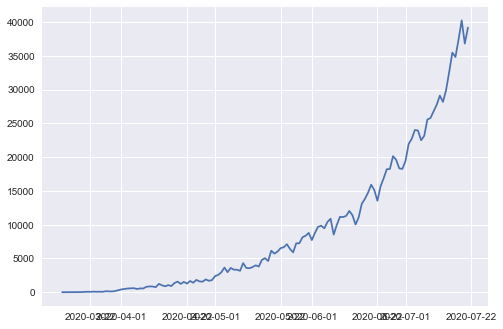

In [317]:
# Since Atleast a 100 new cases per day
# Strong Trend(It is well Understood it has exponential growth in initial stages)
# Difficult to imagine how this'll be stationary
ts = india_data.DailyConfirmed[43:]
plt.plot(ts)
plt.show()

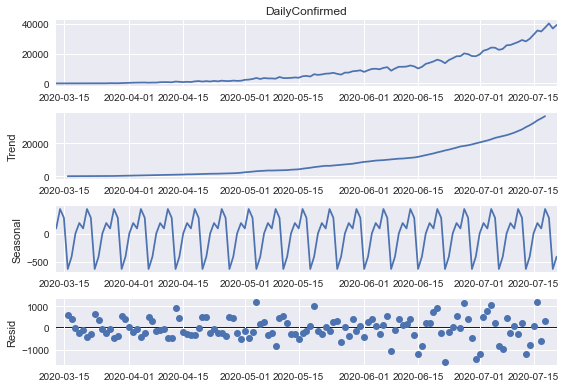

In [318]:
# Decomposing into components
res = seasonal.seasonal_decompose(ts, model='additive', period=None)
plt_season = res.plot()
# Very strong trend and weekly trend - Seems to indicate some testing convention ? less resuls/tests on the weekend

In [319]:
# Augmented Dickey Fuller test to check for unit root and stationarity
def perf_adf(ts):
    """Performs ADF test on time series and prints Results.
    """
    dftest = stattools.adfuller(ts, maxlag=None, autolag='AIC')
    df_result = pd.Series(dftest[:4], index = ['Test- Stat', 'P-Value', '# of Lags Used', '# of Obs Used'])
    # For Critical values at diff. confidence intervals
    for key, value in dftest[4].items():
        df_result[f'Critical Value {key}'] = value
    display(df_result.head(10))

In [320]:
# No Chance of Stationarity
perf_adf(ts)

Test- Stat              4.803162
P-Value                 1.000000
# of Lags Used         13.000000
# of Obs Used         117.000000
Critical Value 1%      -3.487517
Critical Value 5%      -2.886578
Critical Value 10%     -2.580124
dtype: float64

Test- Stat              1.426325
P-Value                 0.997231
# of Lags Used         13.000000
# of Obs Used         116.000000
Critical Value 1%      -3.488022
Critical Value 5%      -2.886797
Critical Value 10%     -2.580241
dtype: float64

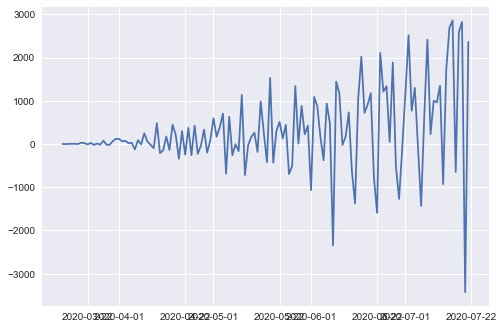

In [321]:
# 1st order difference of lag 1
plt.plot(ts.diff(1))
perf_adf(ts.diff(1).dropna())

Test- Stat             -5.184028
P-Value                 0.000009
# of Lags Used         13.000000
# of Obs Used         115.000000
Critical Value 1%      -3.488535
Critical Value 5%      -2.887020
Critical Value 10%     -2.580360
dtype: float64

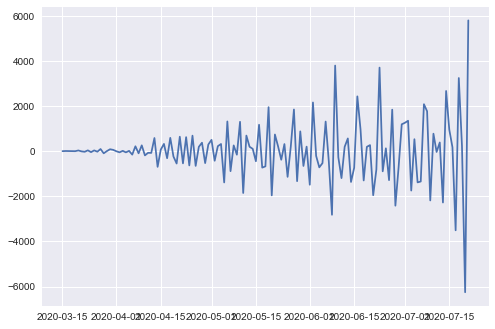

In [322]:
# Differencning by order 2 makes the time series stationary
plt.plot(ts.diff(1).diff(1))
perf_adf(ts.diff(1).diff(1).dropna())

Test- Stat             -3.009966
P-Value                 0.033974
# of Lags Used         13.000000
# of Obs Used         109.000000
Critical Value 1%      -3.491818
Critical Value 5%      -2.888444
Critical Value 10%     -2.581120
dtype: float64

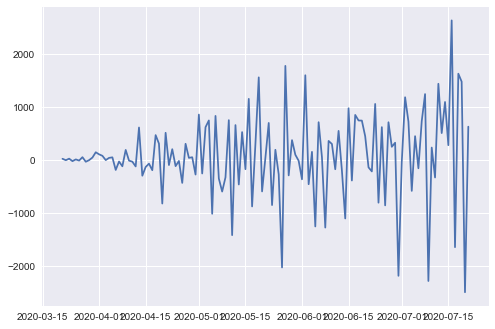

In [323]:
# Removing weekly seasonlity first and then differencing for trend does seem to make it stationary.
perf_adf(ts.diff(7).diff(1).dropna())
plt.plot(ts.diff(7).diff(1).dropna())

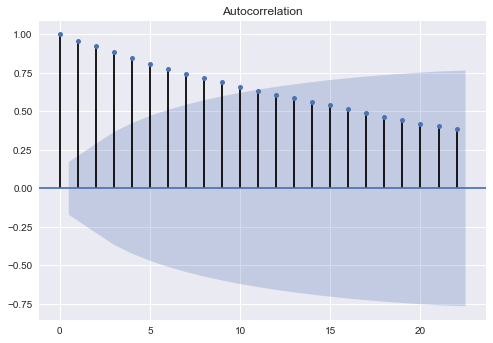

In [324]:
acf = plot_acf(ts)

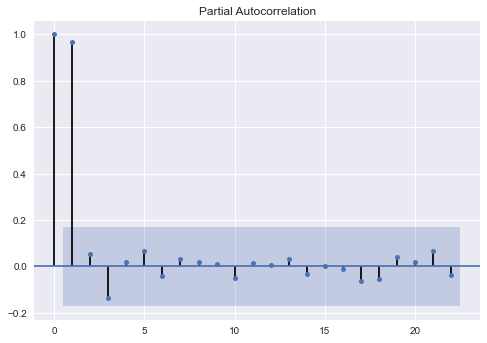

In [325]:
pacf = plot_pacf(ts)

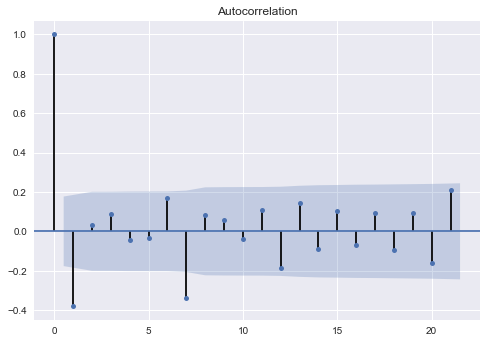

In [326]:
acf = plot_acf(ts.diff(7).diff(1).dropna())

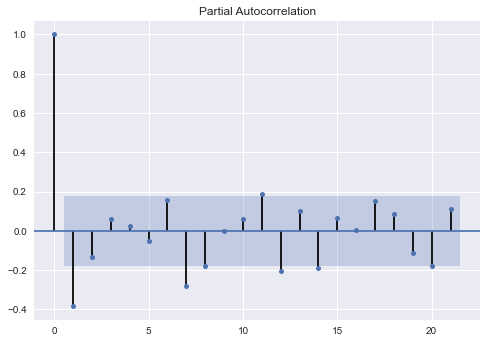

In [327]:
pacf = plot_pacf(ts.diff(7).diff(1).dropna())

### Trying Both ARIMA and SARIMA

In [328]:
ts_train = ts[:-31]
ts_test = ts[-31:]

#### ARIMA

In [329]:
# instantialing model - This has been deprecated
model = arima_model.ARIMA(ts_train, order=(2,1, 1))
# Fitting model 
res_model = model.fit( trend='nc', method='css-mle') # Returns a wrapper to result clas
# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1557.602340985866

In [330]:
res_model.params

ar.L1.D.DailyConfirmed   -0.424175
ar.L2.D.DailyConfirmed   -0.175130
ma.L1.D.DailyConfirmed    0.339261
dtype: float64

In [331]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.DailyConfirmed   No. Observations:                   99
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -774.801
Method:                       css-mle   S.D. of innovations            606.093
Date:                Wed, 22 Jul 2020   AIC                           1557.602
Time:                        19:24:27   BIC                           1567.983
Sample:                    03-14-2020   HQIC                          1561.802
                         - 06-20-2020                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
ar.L1.D.DailyConfirmed    -0.4242      0.308     -1.375      0.169      -1.029       0.180
ar.L2.D.DailyConfirmed    -0.1751      0.101     -1.737      0.082      -0.373       0.023
ma.L1.D.DailyConfirmed     0.3393      0.301      1.127      0.260      -0.251       0.929
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2110           -2.0600j            2.3896           -0.3346
AR.2           -1.2110           +2.0600j            2.3896            0.3346
MA.1           -2.9476           +0.0000j            2.9476            0.5000
-----------------------------------------------------------------------------
"""

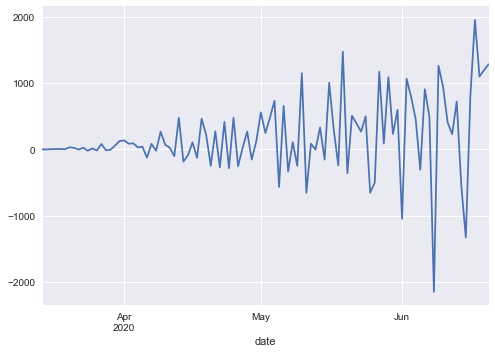

In [332]:
pd.options.plotting.backend = 'matplotlib'
res_model.resid.plot()

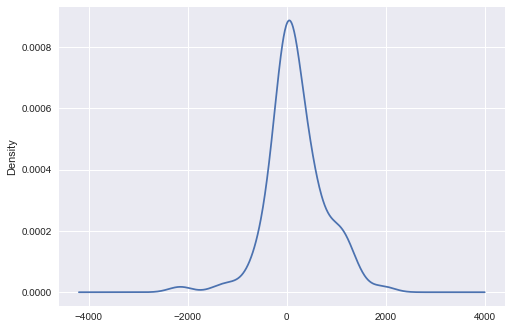

In [333]:
res_model.resid.plot(kind='kde')

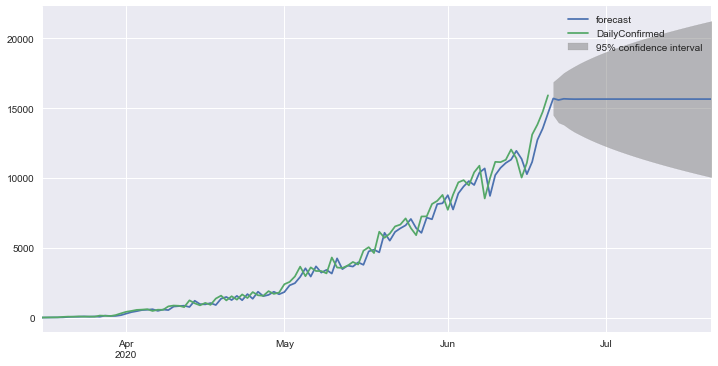

In [334]:
fig = res_model.plot_predict(3, ts_test.index.date[-1])
fig.set_figwidth(12)
fig.set_figheight(6)
plt.show()

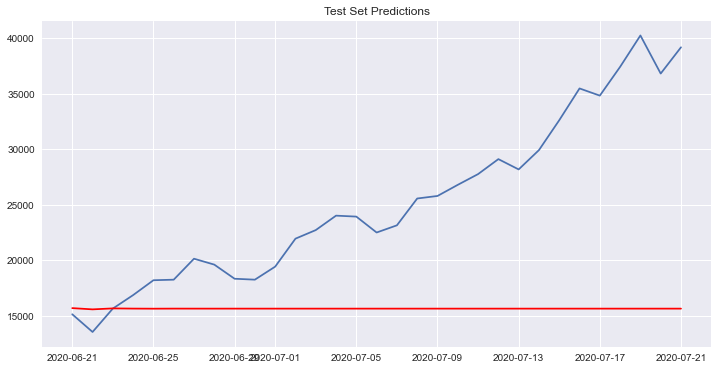

In [335]:
plt.figure(figsize=(12,6))
plt.plot(ts_test)
plt.plot_date(ts_test.index.date,res_model.forecast(len(ts_test))[0], 'r-')
plt.title('Test Set Predictions')
plt.show()

In [336]:
rmse =sqrt(mean_squared_error(ts_test, res_model.forecast(len(ts_test))[0]))
print(rmse)

12121.757671761037


#### SARIMA 

In [337]:
# instantialing model - This has been deprecated
model = sarimax.SARIMAX(ts_train, trend='n', order=(1,1,0), seasonal_order=(0,1,1,7))
# Fitting model 
res_model = model.fit() # Returns a wrapper to result clas
# Using the evaluation metric AIC - AIC rewards goodness of fit (as assessed by the likelihood function), 
# but it also includes a penalty that is an increasing function of the number of estimated parameters.
# Lower is better.
res_model.aic

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



1411.5728990859805

In [338]:
res_model.params

ar.L1          -0.348877
ma.S.L7        -0.470088
sigma2     249414.797147
dtype: float64

In [339]:
res_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      DailyConfirmed   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -702.786
Date:                             Wed, 22 Jul 2020   AIC                           1411.573
Time:                                     19:24:48   BIC                           1419.138
Sample:                                 03-13-2020   HQIC                          1414.626
                                      - 06-20-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3489      0.094     -3.711      0.000      -0.533      -0.165
ma.S.L7       -0.4701      0.078     -6.062      0.000      -0.622      -0.318
sigma2      2.494e+05   2.78e+04      8.978      0.000    1.95e+05    3.04e+05
===================================================================================
Ljung-Box (Q):                       57.01   Jarque-Bera (JB):                12.30
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              13.28   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

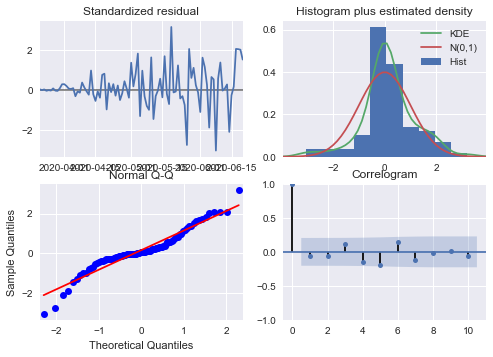

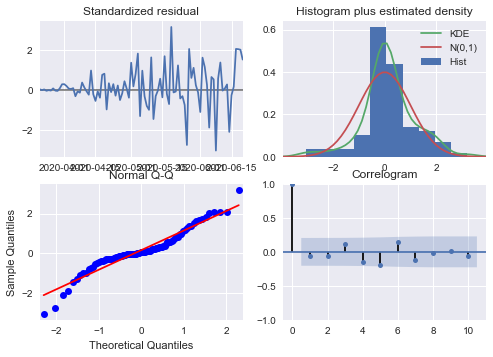

In [340]:
res_model.plot_diagnostics()

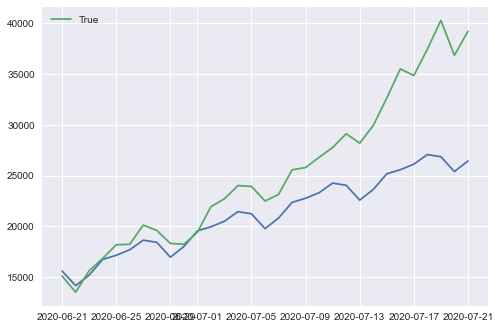

In [342]:
plt.plot(res_model.forecast(len(ts_test)))
plt.plot(ts_test, label = 'True')
plt.legend()
plt.show()

In [343]:
rmse =sqrt(mean_squared_error(ts_test, res_model.forecast(len(ts_test))))
print(rmse)

5652.591248753712


#### Training on Entire Data and Forecasting for Next Month

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



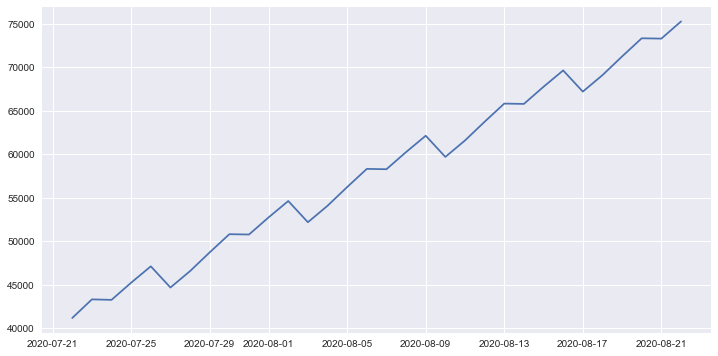

In [357]:
model = sarimax.SARIMAX(ts, trend='n', order=(1,1,0), seasonal_order=(0,1,1,7))
# Fitting model 
res_model = model.fit() # Returns a wrapper to result clas
plt.figure(figsize=(12,6))
plt.plot(res_model.predict(start =len(ts_train + ts_test), end = len(ts_train + ts_test)+31))

### Comparing Lasso Regression and SARIMA

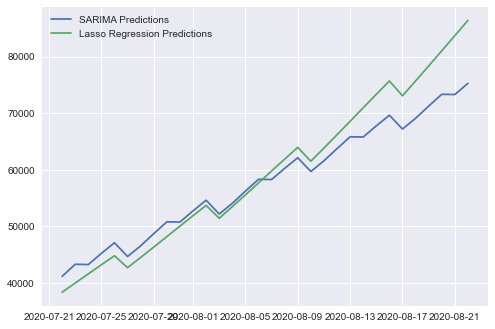

In [358]:
plt.plot(res_model.predict(start =len(ts_train + ts_test), end = len(ts_train + ts_test)+31), label = 'SARIMA Predictions')
plt.plot(x_pre.Predicted_Daily_confirmed, label = 'Lasso Regression Predictions')
plt.legend()
plt.show()

### Tree Based Regression Model - XGBoost Regressor

In [347]:
# Days since widespread data Availibity. 03-12

india_data['Days'] = 0
# -2 due to the fact that last two growth facotrs and ratios are predicted, would be leakage, dropping last two points
x = india_data[['Days','GrowthFactor', 'GrowthRatio']][43:]
x['Days'] = np.arange(1, len(india_data[43:])+1)
x['Day_week'] = x.index.dayofweek.values
y = india_data['DailyConfirmed'][43:]
# Not Shuffling time-Series Data.
x_train, x_test, y_train, y_test = x[:-62], x[-62:], y[:-62], y[-62:]

In [348]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [349]:
x_train_tree = create_features(x_train.drop(['Day_week'], axis = 1))

In [350]:
x_test_tree = create_features(x_test.drop(['Day_week'], axis = 1))

In [351]:
xgb_reg = XGBRegressor(n_estimators = 1000,learning_rate=.3,max_depth=6,
                       n_jobs = -1, objective='reg:squarederror', eval_metric= 'rmse')

In [352]:
xgb_reg.fit(x_train_tree.values, y_train.values, 
             early_stopping_rounds=10, 
             eval_set=[(x_test_tree.values, y_test.values)],
             verbose=True)

[0]	validation_0-rmse:18922.05664
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:18211.79492
[2]	validation_0-rmse:17507.63281
[3]	validation_0-rmse:17067.29297
[4]	validation_0-rmse:16661.04297
[5]	validation_0-rmse:16359.49316
[6]	validation_0-rmse:16072.34180
[7]	validation_0-rmse:15844.62012
[8]	validation_0-rmse:15693.28809
[9]	validation_0-rmse:15547.08594
[10]	validation_0-rmse:15430.72070
[11]	validation_0-rmse:15356.05664
[12]	validation_0-rmse:15280.31543
[13]	validation_0-rmse:15219.89356
[14]	validation_0-rmse:15194.22754
[15]	validation_0-rmse:15174.62109
[16]	validation_0-rmse:15158.76465
[17]	validation_0-rmse:15144.03613
[18]	validation_0-rmse:15131.54492
[19]	validation_0-rmse:15124.00195
[20]	validation_0-rmse:15116.01172
[21]	validation_0-rmse:15110.81250
[22]	validation_0-rmse:15106.39648
[23]	validation_0-rmse:15102.64453
[24]	validation_0-rmse:15099.45898
[25]	validation_0-rmse:15096.75293
[26]	validation_0-rmse:15094.45312


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

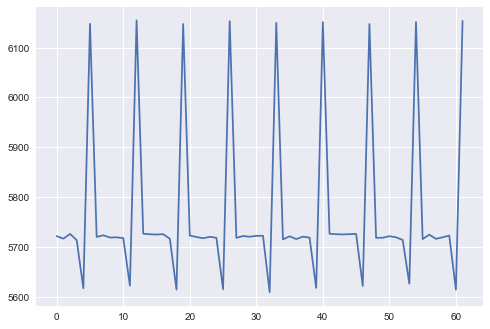

In [353]:
plt.plot(xgb_reg.predict(x_test_tree.values))